In [1]:
import pandas as pd

orders = pd.read_excel("/content/orders.csv.xlsx")
returns = pd.read_excel("/content/returns.csv.xlsx")
products = pd.read_excel("/content/products.csv.xlsx")
customers = pd.read_excel("/content/customers.csv.xlsx")
channels = pd.read_excel("/content/marketing_channels.csv.xlsx")


In [2]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['delivery_date'] = pd.to_datetime(orders['delivery_date'])
returns['return_date'] = pd.to_datetime(returns['return_date'])


In [3]:
print(orders.columns)

Index(['order_id', 'product_id', 'customer_id', 'price', 'discount',
       'order_date', 'delivery_date'],
      dtype='object')


In [4]:
print(returns.columns)

Index(['order_id', 'return_date', 'return_reason'], dtype='object')


In [5]:
print(products.columns)

Index(['product_id', 'category', 'supplier_id'], dtype='object')


In [6]:
print(customers.columns)

Index(['customer_id', 'region', 'age', 'gender'], dtype='object')


In [7]:
print(channels.columns)

Index(['order_id', 'channel'], dtype='object')


In [8]:
# Add 'is_returned' flag
orders['is_returned'] = orders['order_id'].isin(returns['order_id']).astype(int)

# Merge all data
df = orders.merge(products, on='product_id') \
           .merge(customers, on='customer_id') \
           .merge(channels, on='order_id', how='left')


<Axes: xlabel='category'>

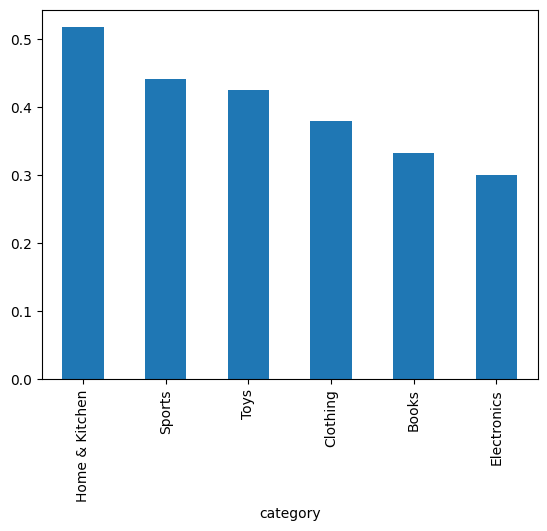

In [9]:
# Return % by Category
df.groupby('category')['is_returned'].mean().sort_values(ascending=False).plot(kind='bar')


<Axes: xlabel='region'>

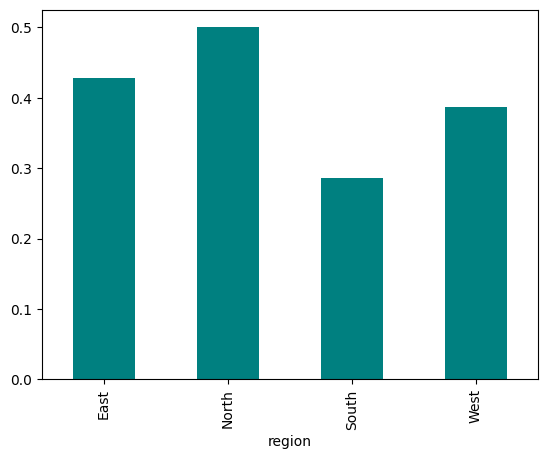

In [10]:
#Return % by Region
df.groupby('region')['is_returned'].mean().plot(kind='bar', color='teal')

<Axes: ylabel='channel'>

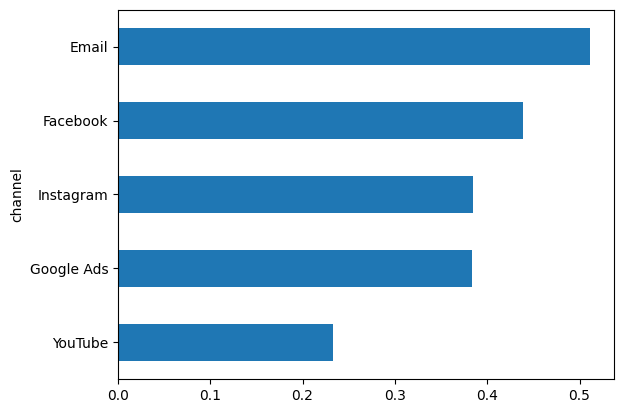

In [11]:
# Return % by Marketing Channel
df.groupby('channel')['is_returned'].mean().sort_values().plot(kind='barh')

<Axes: xlabel='is_returned', ylabel='discount'>

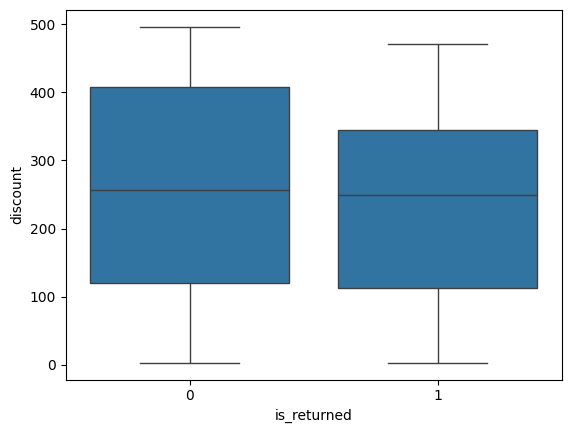

In [12]:
# Discount vs Return Rate
import seaborn as sns
sns.boxplot(x='is_returned', y='discount', data=df)

In [13]:
#  Supplier-wise Return Rates
df.groupby('supplier_id')['is_returned'].mean().sort_values(ascending=False).head()


,is_returned
supplier_id,
S019,0.875000
S012,0.571429
S013,0.533333
S017,0.500000
S011,0.450000


In [14]:
df['discount_pct'] = df['discount'] / df['price']
df['delivery_days'] = (df['delivery_date'] - df['order_date']).dt.days


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

# Features and target
features = ['category', 'region', 'channel', 'discount_pct', 'delivery_days', 'price']
X = pd.get_dummies(df[features], drop_first=True)
y = df['is_returned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.85      0.74        27
           1       0.20      0.08      0.11        13

    accuracy                           0.60        40
   macro avg       0.43      0.46      0.43        40
weighted avg       0.51      0.60      0.54        40



In [16]:
df['return_risk_score'] = model.predict_proba(X)[:, 1]


In [17]:
df[df['return_risk_score'] > 0.7][['order_id', 'product_id', 'return_risk_score']].to_csv("high_risk_products.csv", index=False)
